# Table of Contents
 <p>

In [140]:
#from planet4 import io, region_data, markings
# from p4_tools import get_final_markings_counts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import root, curve_fit, leastsq
import pdb
import shapely.geometry as shp
#import fiona as fio
from shapely import affinity
from shapely.ops import cascaded_union, unary_union
import time

In [172]:
# read out metadata for season 2 and 3
meta = pd.read_csv('ithaca_metadata.csv')

# read out actual markings for fans and blotches, both seasons combined
fans = pd.read_csv('ithaca_fans.csv')
blotches = pd.read_csv('ithaca_blotches.csv')

# read out tile coordinate data
tiles = pd.read_csv('ithaca_tile_coords.csv')

In [173]:
# find unique obsids in the fans and blotches catalogs
fimg_names = fans.image_name.unique()
bimg_names = blotches.image_name.unique()
fimg_id = fans.image_id.unique()
bimg_id = blotches.image_id.unique()

pd.set_option('max_columns', 40)

fans = fans.merge(tiles)
blotches = blotches.merge(tiles)

blotches['area'] = np.pi * blotches.radius_1 * blotches.radius_2

for frame in [fans, blotches]:
    frame['tile_lat'] = frame['PlanetocentricLatitude']
    frame['tile_lon'] = frame['PositiveEast360Longitude']
    frame['image_id'] = frame['image_id']


In [174]:
# find what size fans should be removed for fair comparison
min_fan_pixels = fans.distance.min()
min_bl_area = blotches.area.min()

max_scale = np.max( meta.map_scale.max() )
print('maximum map_scale:',  max_scale, '; min_fan_marking:', min_fan_pixels, '; min_bl_area:', min_bl_area)

# if the minimal fan marking tool is = 10 pixels at max_bin = 4, it will correspond to  
# min_fan_pixels * max_binning / image_binning
meta['min_fan'] = min_fan_pixels * meta.map_scale.max() // meta.map_scale + 1

# if the minimal blotch marking tool is = 80 sq. pixels at max_bin = 4, it will correspond to  
# min_bl_area * max_binning^2 / image_binning^2
meta['min_bl'] = min_bl_area * meta.map_scale.max()**2 // meta.map_scale**2 + 1


maximum map_scale: 1.0 ; min_fan_marking: 10.0 ; min_bl_area: 314.159265359


In [175]:
blotches = blotches.merge(meta)
fans = fans.merge(meta)
blotches['type'] = 'b'
fans['type'] = 'f'

blotches['valid_marking'] = blotches.area > blotches.min_bl
fans['valid_marking'] = fans.distance > fans.min_fan

true_fans = fans[fans.valid_marking==True]
true_blotches = blotches[blotches.valid_marking==True]

In [176]:
objects = pd.concat([true_fans, true_blotches])
objects.head()

,PlanetocentricLatitude,PlanetographicLatitude,PositiveEast360Longitude,Unnamed: 0,angle,area,binning,distance,image_id,image_name,image_x,image_y,invalids,l_s,line_samples,lines,map_scale,min_bl,min_fan,n_votes,...,radius_1,radius_2,real_area,season,spread,tile_lat,tile_lon,type,valid_marking,version,vote_ratio,x,x_angle,x_hirise,x_tile,xy_hirise,y,y_angle,y_hirise,y_tile
0,-85.064139,-85.121792,181.157947,62,208.810277,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",89.036506,APF0000an2,ESP_011350_0945,107.085714,34055.285714,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,63,...,NaN,NaN,2.326323e+07,season2,78.662848,-85.064139,181.157947,f,True,1.0,NaN,107.085714,-0.829266,420.0,1,"(420.0, 34300.0)",79.285714,-0.456087,34300.0,63
1,-85.064139,-85.121792,181.157947,62,211.974420,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",98.485588,APF0000an2,ESP_011350_0945,770.463636,34392.288312,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,77,...,NaN,NaN,2.326323e+07,season2,62.082168,-85.064139,181.157947,f,True,1.0,NaN,770.463636,-0.744282,420.0,1,"(420.0, 34300.0)",416.288312,-0.464617,34300.0,63
2,-85.064139,-85.121792,181.157947,62,207.651635,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",60.479072,APF0000an2,ESP_011350_0945,252.687301,34186.139683,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,63,...,NaN,NaN,2.326323e+07,season2,89.829668,-85.064139,181.157947,f,True,1.0,NaN,252.687301,-0.845097,420.0,1,"(420.0, 34300.0)",210.139683,-0.442776,34300.0,63
3,-85.064139,-85.121792,181.157947,62,200.813312,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",28.651956,APF0000an2,ESP_011350_0945,714.342105,34438.842105,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,19,...,NaN,NaN,2.326323e+07,season2,64.990934,-85.064139,181.157947,f,True,1.0,0.643333,714.342105,-0.920060,420.0,1,"(420.0, 34300.0)",462.842105,-0.349743,34300.0,63
4,-85.173719,-85.230104,181.303269,103,158.552456,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",72.472999,APF0000an3,ESP_011350_0945,1455.916667,22532.833333,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,6,...,NaN,NaN,2.326323e+07,season2,69.989781,-85.173719,181.303269,f,True,1.0,NaN,715.916667,-0.920699,1160.0,2,"(1160.0, 22244.0)",612.833333,0.361700,22244.0,41


In [177]:

objects.rename(columns={'image_name':'name'}, inplace=True)
# objects.binning.iloc[0]
# def get_bins(binning):
#     arr = np.fromstring(binning.strip('[]'), dtype=np.int, sep=',')
#     return arr[4]
# objects.head(4)

In [178]:
# get list of unique images
img_unique = objects.name.unique()

# add columns for coverage and season in the meta dataframe
# meta['coverage'] = 0
# meta['coverage_redundant'] = 0


# record type of each object - they are still in order from concatenation so this can be done with indexing
# split = len(fans.valid_marking[fans.valid_marking==True])
# objects.loc[:split,'type'] = 'f'
# objects.loc[split:,'type'] = 'b'

#re-sort objects according to image, so that blotches and fans for the same image won't be split up
objects = objects.sort_values(by='name').reset_index(drop=True)
meta = meta.sort_values(by='obsid').reset_index(drop=True)
objects.shape

(32168, 43)

In [179]:
%matplotlib inline

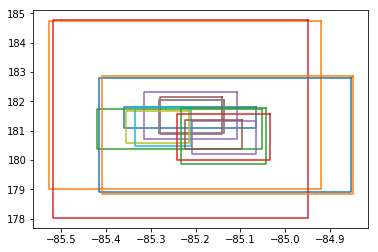

In [180]:
# create a list to store points corresponding to the corners (bounds) of each HiRise image
# and a list to store the polygons made from the sets of points
points = [None] * 4
img_shapes = [None] * len(img_unique)
plt.figure(1)
for i,img_name in enumerate(img_unique):
    df = objects.query('name==@img_name')
    boundshi = df.tile_lat.max()
    boundsri = df.tile_lon.max()
    boundslo = df.tile_lat.min()
    boundsle = df.tile_lon.min()
    points[0] = (boundshi,boundsri)
    points[1] = (boundslo,boundsri)
    points[2] = (boundslo,boundsle)
    points[3] = (boundshi,boundsle)
    img_shapes[i] = shp.Polygon(points[:])
    # plot the outlines of the HiRise images as an example
    x,y = img_shapes[i].exterior.xy
    plt.plot(x,y);
    

In [181]:
# create arrays to store info on non-overlapping images
misses = np.zeros((len(img_unique),len(img_unique)))
ind2drop = np.zeros((len(img_unique)),dtype=int)

# loop through images
for i in range(len(img_unique)):
    # loop through other images to check image [i]
    for j in range(len(img_unique)-i-1):
        # check if image[i] intersects the current image, if not, add a 1 in 'misses' array 
        # with index corresponding to the two non-overlapping images
        if img_shapes[i].intersects(img_shapes[i+j+1])==False:
            misses[i,i+j+1] = 1 

# loop through possible cases of non-overlap
for n in range(len(img_unique)):
    # if all images intersect somewhwere, misses will be only zeros and the loop should be broken
    if np.sum(misses)==0:
        break
    # get indices of flags in 'misses'
    miss_inds = np.where(misses!=0)
    # get which images were involved, sort by involvement
    miss_unique = np.unique(miss_inds,return_counts=True)
    # find which image came up the most in 'misses' - this is the one to remove next iteration
    miss_max = max(miss_unique[1])
    miss_max_ind = np.where(miss_unique[1]==miss_max)[0][0]
    # get the index of that image in the collection of polygons 'img_shapes', add one so that 
    # the index '0' wouldn't get missed
    ind2drop[n] = int(miss_unique[0][miss_max_ind]) + 1
    # clear 'misses' of any flags corresponding to that image becuase it has been found all ready
    misses[:,int(ind2drop[n])-1] = 0
    misses[int(ind2drop[n])-1,:] = 0

In [182]:
# trim off excess zeroes in 'ind2drop'
ind2drop = np.delete(ind2drop,np.where(ind2drop==0.0))

# 'safe' is 1 where the index refers to an object to-be-dropped, and 0 otherwise (zeroes are safe objects)
safe = np.zeros((len(img_unique)))
safe[ind2drop-1] = 1

# 'safes' are the indices of all safe objects, the first of which is the starting point for the next loop,
# which is necessary to know in cases where the first few images are to-be-dropped
safes = np.where(safe==0)
start = int(safes[0][0])

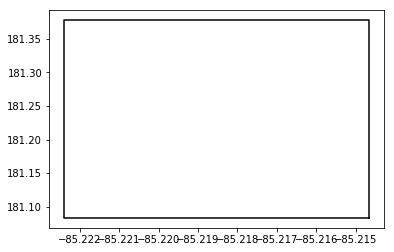

In [183]:
# loop through images to define area with highest degree of overlap
for i in range(len(img_unique)):
    # first iteration - intersection of first and second object is the temporary object
    if i == 0:
        inter_temp = img_shapes[i].intersection(img_shapes[i+1])
        # if '0' or '1' is an index-to-drop, temporary object is just the first safe object
        if any([z-1==i for z in ind2drop]) or any([z-1==i+1 for z in ind2drop]):
            inter_temp = img_shapes[start]
        continue
    # if this is the last iteration, temporary object is the final object
    elif i == (len(img_unique)-1):
        inter = inter_temp
        break
    # if the loop is on an index-to-drop, continue to next iteration, omitting this object
    # from the calculation of 'inter'
    elif any([z-1==i+1 for z in ind2drop])==True:
        continue
    # normal action - update temporary object as intersection with the next object in 'img_shapes'
    else:
        inter_temp = inter_temp.intersection(img_shapes[i+1])

# plot the outline of the most overlapped area found in black, should look reasonable on previous plot
xi,yi = inter.exterior.xy
plt.plot(xi,yi,'k')
plt.show()

In [184]:
# 'buffer' is a factor that determines how far inside or outside the extents of 'inter' an object's tile's 
# must be to be considered for calculation. a positive number allows objects outside 'inter' to be considered
buffer = .0005
# define lat/lon corresponding to corners of 'inter'
lo_lat = xi[2] * (1. + buffer)
hi_lat = xi[0] * (1. - buffer)
lo_lon = yi[0] * (1. - buffer)
hi_lon = yi[2] * (1. + buffer)

# 'overlap_objs' are all the objects whose tile center is within the allowable distance around 'inter'
overlap_objs = objects.loc[(objects['tile_lat'] > lo_lat) & (objects['tile_lon'] < hi_lon) & (objects['tile_lat'] < hi_lat) & (objects['tile_lon'] > lo_lon)]
overlap_objs = overlap_objs.reset_index(drop=True)
ol_img_unique = overlap_objs.name.unique()

In [185]:
overlap_objs.shape

(5042, 43)

In [186]:
# create arrays to be filled
n_ol_img = len(ol_img_unique)
n_marks = np.zeros((n_ol_img,3))
n_objs = overlap_objs.name.value_counts()[0]
img_fans = np.zeros((n_ol_img,n_objs))
img_blotches = np.zeros((n_ol_img,n_objs))
f_histmax = np.zeros((n_ol_img))
b_histmax = np.zeros((n_ol_img))
collection = [None] * len(overlap_objs)
points = [None] * 14
areas = np.zeros(len(overlap_objs))
img_areas = np.zeros(len(ol_img_unique))
tile_log = []

overlap_objs.head(10)

,PlanetocentricLatitude,PlanetographicLatitude,PositiveEast360Longitude,Unnamed: 0,angle,area,binning,distance,image_id,name,image_x,image_y,invalids,l_s,line_samples,lines,map_scale,min_bl,min_fan,n_votes,...,radius_1,radius_2,real_area,season,spread,tile_lat,tile_lon,type,valid_marking,version,vote_ratio,x,x_angle,x_hirise,x_tile,xy_hirise,y,y_angle,y_hirise,y_tile
0,-85.242572,-85.29816,181.455139,89,221.766383,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",104.453064,APF0000aqg,ESP_011350_0945,1518.730000,14489.680000,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,25,...,NaN,NaN,2.326323e+07,season2,65.964552,-85.242572,181.455139,f,True,1.0,0.704444,778.730000,-0.723678,1160.0,2,"(1160.0, 14572.0)",241.680000,-0.646279,14572.0,27
1,-85.242572,-85.29816,181.455139,89,217.804524,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",73.948012,APF0000aqg,ESP_011350_0945,1451.075000,14606.200000,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,30,...,NaN,NaN,2.326323e+07,season2,77.446682,-85.242572,181.455139,f,True,1.0,0.843333,711.075000,-0.758341,1160.0,2,"(1160.0, 14572.0)",358.200000,-0.588325,14572.0,27
2,-85.242572,-85.29816,181.455139,89,237.103717,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",70.717034,APF0000aqg,ESP_011350_0945,1343.481373,14716.176471,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,17,...,NaN,NaN,2.326323e+07,season2,69.659650,-85.242572,181.455139,f,True,1.0,0.663846,603.481373,-0.532440,1160.0,2,"(1160.0, 14572.0)",468.176471,-0.823144,14572.0,27
3,-85.242572,-85.29816,181.455139,89,230.957111,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",56.780333,APF0000aqg,ESP_011350_0945,1290.729825,14741.736842,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,19,...,NaN,NaN,2.326323e+07,season2,81.690641,-85.242572,181.455139,f,True,1.0,0.740769,550.729825,-0.603686,1160.0,2,"(1160.0, 14572.0)",493.736842,-0.744350,14572.0,27
4,-85.242572,-85.29816,181.455139,89,233.332192,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",83.649484,APF0000aqg,ESP_011350_0945,1257.534167,14577.950000,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,20,...,NaN,NaN,2.326323e+07,season2,76.443053,-85.242572,181.455139,f,True,1.0,0.810000,517.534167,-0.588255,1160.0,2,"(1160.0, 14572.0)",329.950000,-0.790131,14572.0,27
5,-85.242572,-85.29816,181.455139,89,228.558918,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",101.004818,APF0000aqg,ESP_011350_0945,1324.638406,14562.913043,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,23,...,NaN,NaN,2.326323e+07,season2,64.827397,-85.242572,181.455139,f,True,1.0,0.615263,584.638406,-0.649357,1160.0,2,"(1160.0, 14572.0)",314.913043,-0.735487,14572.0,27
6,-85.242572,-85.29816,181.455139,89,214.004559,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",92.414725,APF0000aqg,ESP_011350_0945,1218.509259,14326.370370,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,27,...,NaN,NaN,2.326323e+07,season2,74.488126,-85.242572,181.455139,f,True,1.0,0.804118,478.509259,-0.788176,1160.0,2,"(1160.0, 14572.0)",78.370370,-0.531722,14572.0,27
7,-85.242572,-85.29816,181.455139,89,214.004559,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",92.414725,APF0000aqg,ESP_011350_0945,1218.509259,14326.370370,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,27,...,NaN,NaN,2.326323e+07,season2,74.488126,-85.242572,181.455139,f,True,1.0,0.828182,478.509259,-0.788176,1160.0,2,"(1160.0, 14572.0)",78.370370,-0.531722,14572.0,27
8,-85.242572,-85.29816,181.455139,89,225.499171,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",67.072037,APF0000aqg,ESP_011350_0945,1024.168116,14375.130435,0.697406,181.205092,8168,37649,0.5,1257.0,21.0,23,...,NaN,NaN,2.326323e+07,season2,81.702033,-85.242572,181.455139,f,True,1.0,0.667143,284.168116,-0.669062,1160.0,2,"(1160.0, 14572.0)",127.130435,-0.680822,14572.0,27
9,-85.242572,-85.29816,181.455139,89,217.619338,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",73.217755,APF0000aqg,ESP_011350_0945,1557.055556,14307.888889,0.697406,181.2050

In [187]:
overlap_objs.name.value_counts()

ESP_021491_0950    821
ESP_020146_0950    625
ESP_020568_0950    606
ESP_012643_0945    433
ESP_020779_0950    383
ESP_012063_0945    376
ESP_012076_0945    363
ESP_012858_0855    258
ESP_011350_0945    252
ESP_011931_0945    193
ESP_020476_0950    190
ESP_020357_0950    187
ESP_011404_0945    143
ESP_011403_0945     84
ESP_011351_0945     82
ESP_012854_0945     46
Name: name, dtype: int64

In [188]:
for k in range(len(overlap_objs)):
    if overlap_objs.type[k]=='f':
        r = overlap_objs.distance[k]*np.tan((overlap_objs.spread[k]/2.)*np.pi/180.)
        red_ax = overlap_objs.distance[k] - r
        points[0] = (overlap_objs.image_x[k],overlap_objs.image_y[k])
        points[1] = (overlap_objs.image_x[k] + r,overlap_objs.image_y[k] + red_ax)
        points[2] = (overlap_objs.image_x[k] + r*np.cos(15.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(15.*np.pi/180.) + red_ax)
        points[3] = (overlap_objs.image_x[k] + r*np.cos(30.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(30.*np.pi/180.) + red_ax)
        points[4] = (overlap_objs.image_x[k] + r*np.cos(45.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(45.*np.pi/180.) + red_ax)
        points[5] = (overlap_objs.image_x[k] + r*np.cos(60.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(60.*np.pi/180.) + red_ax)
        points[6] = (overlap_objs.image_x[k] + r*np.cos(75.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(75.*np.pi/180.) + red_ax)
        points[7] = (overlap_objs.image_x[k] + r*np.cos(90.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(90.*np.pi/180.) + red_ax)
        points[8] = (overlap_objs.image_x[k] + r*np.cos(105.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(105.*np.pi/180.) + red_ax)
        points[9] = (overlap_objs.image_x[k] + r*np.cos(120.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(120.*np.pi/180.) + red_ax)
        points[10] = (overlap_objs.image_x[k] + r*np.cos(135.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(135.*np.pi/180.) + red_ax)
        points[11] = (overlap_objs.image_x[k] + r*np.cos(150.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(150.*np.pi/180.) + red_ax)
        points[12] = (overlap_objs.image_x[k] + r*np.cos(165.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(165.*np.pi/180.) + red_ax)
        points[13] = (overlap_objs.image_x[k] + r*np.cos(180.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(180.*np.pi/180.) + red_ax)
        collection[k] = shp.Polygon(points[:])
        collection[k] = affinity.rotate(collection[k],angle=overlap_objs.angle[k] - 90.,origin=points[0])
        areas[k] = collection[k].area
    else:
        circle = shp.point.Point(overlap_objs.image_x[k],overlap_objs.image_y[k]).buffer(1)
        collection[k] = affinity.scale(circle,overlap_objs.radius_1[k],overlap_objs.radius_2[k])
        collection[k] = affinity.rotate(collection[k],angle=overlap_objs.angle[k])
        areas[k] = collection[k].area

In [189]:
i = 0
overlap_objs.image_id[(overlap_objs.name==ol_img_unique[i])]

0      APF0000aqg
1      APF0000aqg
2      APF0000aqg
3      APF0000aqg
4      APF0000aqg
5      APF0000aqg
6      APF0000aqg
7      APF0000aqg
8      APF0000aqg
9      APF0000aqg
10     APF0000aqg
11     APF0000aqg
12     APF0000aqg
13     APF0000ant
14     APF0000ant
15     APF0000ant
16     APF0000ant
17     APF0000ant
18     APF0000ans
19     APF0000ans
20     APF0000ans
21     APF0000ans
22     APF0000ana
23     APF0000ana
24     APF0000ana
25     APF0000ana
26     APF0000apr
27     APF0000apr
28     APF0000apr
29     APF0000apr
          ...    
222    APF0000apn
223    APF0000apn
224    APF0000apn
225    APF0000aon
226    APF0000aon
227    APF0000aon
228    APF0000aon
229    APF0000aon
230    APF0000aon
231    APF0000aom
232    APF0000aom
233    APF0000aom
234    APF0000aom
235    APF0000aom
236    APF0000aom
237    APF0000aom
238    APF0000aom
239    APF0000aon
240    APF0000aon
241    APF0000aon
242    APF0000aon
243    APF0000aon
244    APF0000aon
245    APF0000aoy
246    APF

In [192]:
tile_size = 544320

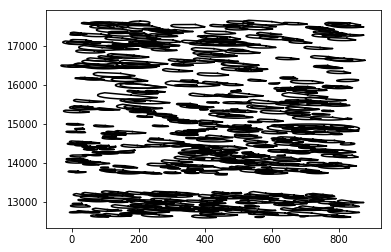

In [203]:
for i,img_name in enumerate(ol_img_unique):
    df = overlap_objs.query('name==@img_name')
    map_scale = meta.query('obsid==@img_name').map_scale.values[0]
    # get set of fans & blotches for each image, and get list of tiles in which these are contained
    fans_ = df.query('type=="f"')
    blotches_ = df.query('type=="b"')
    tile_log.append(df.image_id.unique())
    
    current_Ls = df.l_s.values[0]
#     # for each image, record l_s and the number of fans & blotches divided by the number of tiles considered
    if len(fans_) > 0 and len(blotches_) > 0:
        n_marks[i,0] = current_Ls
        try:
            n_marks[i,1] = len(fans_)/(fans_.image_id.nunique() * tile_size/100 * (fans_.map_scale.reset_index(drop=True)[0])**2)
        except ZeroDivisionError:
            n_marks[i,1] = np.nan
        try:
            n_marks[i,2] = len(blotches_)/(blotches_.image_id.nunique() * tile_size/100 * (blotches_.map_scale.reset_index(drop=True)[0])**2)
        except ZeroDivisionError:
            n_marks[i,2] = np.nan
    
    # get lengths and binnings of fans & blotches for each image, multiply these, fill length array (for fans)
    # and area array (for blotches) with result
    fan_lengths = fans_.distance
    img_fans[i,:len(fans_)] = fan_lengths * map_scale
    blotch_len1 = blotches_.radius_1
    blotch_len2 = blotches_.radius_2
    img_blotches[i,:len(blotches_)] = blotch_len1 * blotch_len2 * np.pi * map_scale
    
    # create a histogram of fans' & blotches' size distribution for each image,
    # find max of each histogram, record in 'histmax'
    f_hist,f_binedges = np.histogram(img_fans[i,np.where(img_fans[i,:]>0.0)],bins=50)
    f_histmax[i] = f_binedges[np.where(f_hist==f_hist.max())[0][0]]
    b_hist,b_binedges = np.histogram(img_blotches[i,np.where(img_blotches[i,:]>0.0)],bins=50)
    b_histmax[i] = b_binedges[np.where(b_hist==b_hist.max())[0][0]]
    # replace zeroes with NaN's
    if f_histmax[i]==0:
        f_histmax[i] = np.nan
    if b_histmax[i]==0:
        b_histmax[i] = np.nan
    if n_marks[i,0]==0:
        n_marks[i,0] = np.nan
    if n_marks[i,1]==0:
        n_marks[i,1] = np.nan
    if n_marks[i,2]==0:
        n_marks[i,2] = np.nan
    if i==0:
        ind = len(df)
        img_areas[i] = unary_union(collection[:ind]).area / df.image_id.nunique()
    else:
        ind_minus = ind
        ind = ind_minus + len(np.where(overlap_objs.name==ol_img_unique[i])[0])
        img_areas[i] = unary_union(collection[ind_minus:ind]).area / df.image_id.nunique()

    if i == 10:
        plt.figure()
        for points in collection[ind_minus:ind]:
            xi,yi = points.exterior.xy
            plt.plot(xi,yi,'k')
        plt.show()

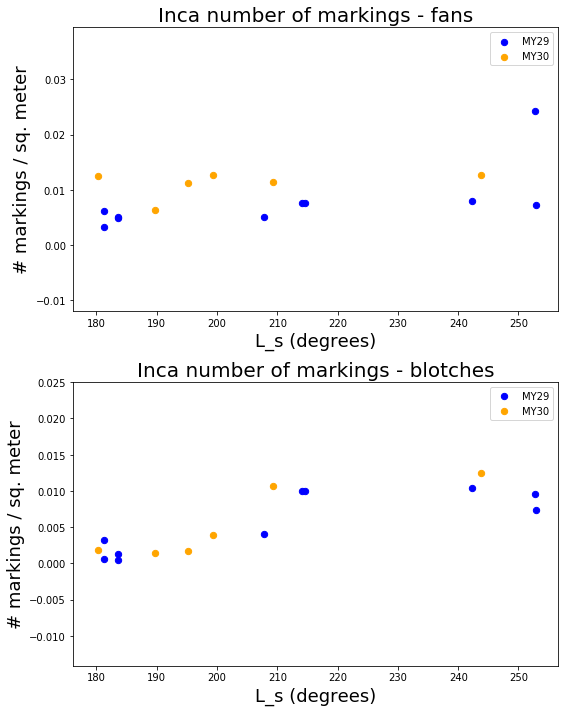

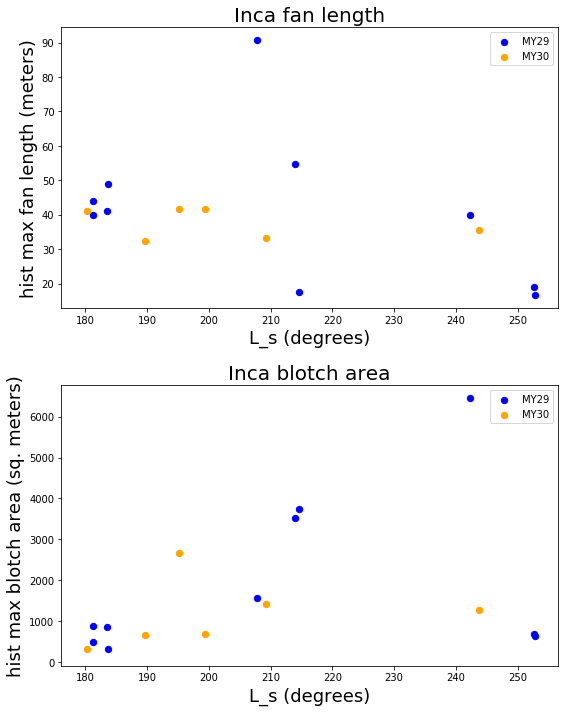

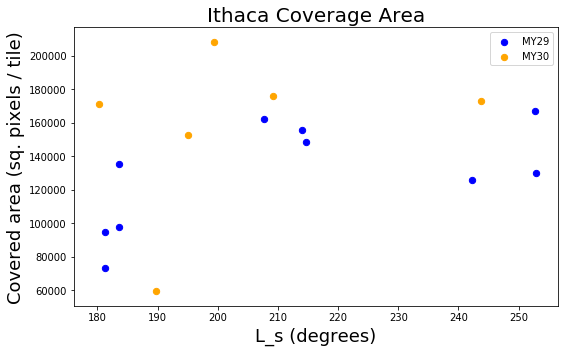

In [204]:
# plot data

txtfile = open('inca_tiles.txt', 'w')
for item in tile_log:
  txtfile.write("%s\n" % item)

s = 40
season_split = len(meta[meta.season=='season2'])
plt.figure(2,figsize=(8,10))
plt.subplot(211)
plt.scatter(n_marks[:season_split,0],n_marks[:season_split,1],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],n_marks[season_split:,1],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Inca number of markings - fans',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('# markings / sq. meter',fontsize=18)
plt.subplot(212)
plt.scatter(n_marks[:season_split,0],n_marks[:season_split,2],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],n_marks[season_split:,2],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Inca number of markings - blotches',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('# markings / sq. meter',fontsize=18)
plt.tight_layout()
plt.savefig('in_n_marks.png')
plt.figure(3,figsize=(8,10))
plt.subplot(211)
plt.scatter(n_marks[:season_split,0],f_histmax[:season_split],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],f_histmax[season_split:],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Inca fan length',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('hist max fan length (meters)',fontsize=18)
plt.subplot(212)
plt.scatter(n_marks[:season_split,0],b_histmax[:season_split],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],b_histmax[season_split:],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Inca blotch area',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('hist max blotch area (sq. meters)',fontsize=18)
plt.tight_layout()
plt.savefig('in_marksize.png')
plt.figure(4,figsize=(8,5))
plt.subplot(111)
plt.scatter(n_marks[:season_split,0],img_areas[:season_split],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],img_areas[season_split:],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Ithaca Coverage Area',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('Covered area (sq. pixels / tile)',fontsize=18)
plt.tight_layout()
plt.savefig('in_covg.png')
plt.show()


In [200]:
print(n_marks)

[[  1.81205092e+02   6.24632569e-05   3.17150902e-05]
 [  1.81249083e+02   3.21502058e-05   5.51146384e-06]
 [  1.83549487e+02   5.14403292e-05   1.28600823e-05]
 [  1.83593752e+02   4.96031746e-05   4.89907897e-06]
 [  2.07750946e+02   5.14403292e-05   4.04174015e-05]
 [  2.14019732e+02   7.60798146e-05   9.96146058e-05]
 [  2.14641238e+02   7.66561769e-05   9.94224850e-05]
 [  2.42278661e+02   8.05814024e-05   1.04598517e-04]
 [  2.52710250e+02   2.42504409e-04   9.55320400e-05]
 [  2.52907035e+02   7.17903496e-05   7.40514629e-05]
 [  1.80310799e+02   1.25615447e-04   1.79122575e-05]
 [  1.89712746e+02   6.34301804e-05   1.40848520e-05]
 [  1.95125296e+02   1.11565389e-04   1.69018225e-05]
 [  1.99362248e+02   1.27103882e-04   3.92868448e-05]
 [  2.09241491e+02   1.13903586e-04   1.07235395e-04]
 [  2.43829437e+02   1.26524040e-04   1.24926514e-04]]


In [201]:
print(img_areas)

[  73089.78234464   94914.77475385   97967.35143335  135347.52181883
  161884.24145818  155359.4470701   148598.69752863  125990.81413832
  166829.7651835   129690.82420085  171126.81838733   59604.22091387
  152409.32189902  208020.18130478  175961.83454531  172941.54388372]


In [202]:
meta.head(20)


,binning,invalids,l_s,line_samples,lines,map_scale,north_azimuth,obsid,path,real_area,season,min_fan,min_bl
0,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.697406,181.205092,8168,37649,0.50,99.672793,ESP_011350_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,2.326323e+07,season2,21.0,1257.0
1,"[-9998, -9998, -9998, -9998, 4, 4, -9998, -999...",0.949729,181.249083,30049,40496,1.00,127.960688,ESP_011351_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,6.117331e+07,season2,11.0,315.0
2,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.839598,183.549487,14771,45258,0.50,106.472204,ESP_011403_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,2.680740e+07,season2,21.0,1257.0
3,"[-9998, -9998, -9998, -9998, 4, 4, -9998, -999...",0.949674,183.593752,34927,37137,1.00,134.130277,ESP_011404_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,6.527651e+07,season2,11.0,315.0
4,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.857730,207.750946,16916,26537,0.50,122.704475,ESP_011931_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.596621e+07,season2,21.0,1257.0
5,"[-9998, -9998, -9998, -9998, 1, 1, -9998, -999...",0.813321,214.019732,25791,34943,0.25,127.542396,ESP_012063_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.051484e+07,season2,41.0,5027.0
6,"[-9998, -9998, -9998, -9998, 1, 1, -9998, -999...",0.801042,214.641238,22962,36382,0.25,122.275837,ESP_012076_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.038813e+07,season2,41.0,5027.0
7,"[-9998, -9998, -9998, -9998, 1, 1, -9998, -999...",0.800882,242.278661,22904,36401,0.25,122.216966,ESP_012643_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.037565e+07,season2,41.0,5027.0
8,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.802872,252.710250,11634,18186,0.50,121.484434,ESP_012854_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.042691e+07,season2,21.0,1257.0
9,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.821952,252.907035,14854,16089,0.50,230.067668,ESP_012858_0855,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.063775e+07,season2,21.0,1257.0
